In [1]:

import warnings
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import os
import copy
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from multi_gran_generator import creat_coarse_data, creat_coarse_data_elec
from mgtsd_estimator import mgtsdEstimator
from trainer import Trainer
from pathlib import Path
import wandb
import ast
from utils import plot
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

alias = {
    'elec': 'electricity_nips',
    'wiki': 'wiki-rolling_nips',
    'cup': 'kdd_cup_2018_without_missing',
    'solar': 'solar_nips',
    'traf': 'traffic_nips',
    'taxi': 'taxi_30min'
}
input_size_all = {
    'solar': 552,
    'cup': 1084,
    'traf': 3856,
    'taxi': 7290,
    'elec': 1484,
    'wiki': 8002,
}
feature_size_all = {
    'fred': 107,
    'solar': 137,
    'cup': 270,
    'traf': 963,
    'taxi': 1214,
    'elec': 370,
    'wiki': 2000,
}

model_name = "mgtsd"
cuda_num = 0
dataset_name = "elec"
epoch = 30
diff_steps = 100
num_gran = 2
mg_dict = "1_4"
share_ratio_list = "1_0.8"
weight_list = "0.8_0.2"

input_size = input_size_all[dataset_name]
batch_size = 128
mg_dict = [float(i) for i in str(mg_dict).split('_')]
print(f"mg_dict:{mg_dict}")
share_ratio_list = [float(i) for i in str(share_ratio_list).split('_')]
print(f"share_ratio_list:{share_ratio_list}")
weight_list = [float(i) for i in str(weight_list).split('_')]
weights = weight_list
print(f"share_ratio_list:{share_ratio_list}")
learning_rate = 1e-05
num_cells = 128


device = torch.device(
    f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")


/home/v-wuyueying/miniconda3/envs/mgtsd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/v-wuyueying/miniconda3/envs/mgtsd/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


self.log_matrics: None
mg_dict:[1.0, 4.0]
share_ratio_list:[1.0, 0.8]
share_ratio_list:[1.0, 0.8]


In [2]:
print("================================================")
print("prepare the dataset")
dataset = get_dataset(alias[dataset_name], regenerate=False)

train_grouper = MultivariateGrouper(max_target_dim=min(
    2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)),
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)
if dataset_name == 'elec':
    data_train, data_test = creat_coarse_data_elec(dataset_train=dataset_train,
                                                   dataset_test=dataset_test,
                                                   mg_dict=mg_dict)
else:
    data_train, data_test = creat_coarse_data(dataset_train=dataset_train,
                                              dataset_test=dataset_test,
                                              mg_dict=mg_dict)
print(f'dataset_train0_len:{len(data_train[0]["target"][0])}')
print(f'dataset_test0_len:{len(data_test[0]["target"][0])}')

prepare the dataset


dataset_train0_len:5832
dataset_test0_len:4144


In [3]:
print("================================================")
print("initlize the estimator")

estimator = mgtsdEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=input_size,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=diff_steps,
    share_ratio_list=share_ratio_list,
    beta_end=0.1,
    beta_schedule="linear",
    weights=weights,
    num_cells=num_cells,
    num_gran=num_gran,
    trainer=Trainer(device=device,
                    epochs=epoch,
                    learning_rate=learning_rate,
                    num_batches_per_epoch=100,
                    batch_size=batch_size,
                    log_matrics=False)
)
print("================================================")
print("start training the network")
predictor = estimator.train(
    data_train, num_workers=8, validation_data=data_test)

print("===============================================")
print("make predictions")
forecast_it, ts_it = make_evaluation_predictions(dataset=data_test,
                                                 predictor=predictor,
                                                 num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

targets_list = []
forecasts_list = []
target_dim = estimator.target_dim
target_columns = targets[0].iloc[:, :target_dim].columns
for cur_gran_index, cur_gran in enumerate(mg_dict):
    targets_cur = []
    predict_cur = []
    predict_cur = copy.deepcopy(forecasts)

    for i in range(len(targets)):
        targets_cur.append(
            targets[i].iloc[:, (cur_gran_index * target_dim):((cur_gran_index + 1) * target_dim)])
        targets_cur[-1].columns = target_columns
    for day in range(len(forecasts)):
        predict_cur[day].samples = forecasts[day].samples[:, :,
                                                          (cur_gran_index * target_dim):((cur_gran_index + 1) * target_dim)]
    targets_list.append(targets_cur)
    forecasts_list.append(predict_cur)


initlize the estimator
self.log_matrics: False
start training the network
self_share_ratio of estimator:[1.0, 0.8]


100%|██████████| 99/99 [00:12<00:00,  7.92it/s, epoch=30/30, avg_loss=0.0951, avg_val_loss=0.0993]


init the prediction network
make predictions


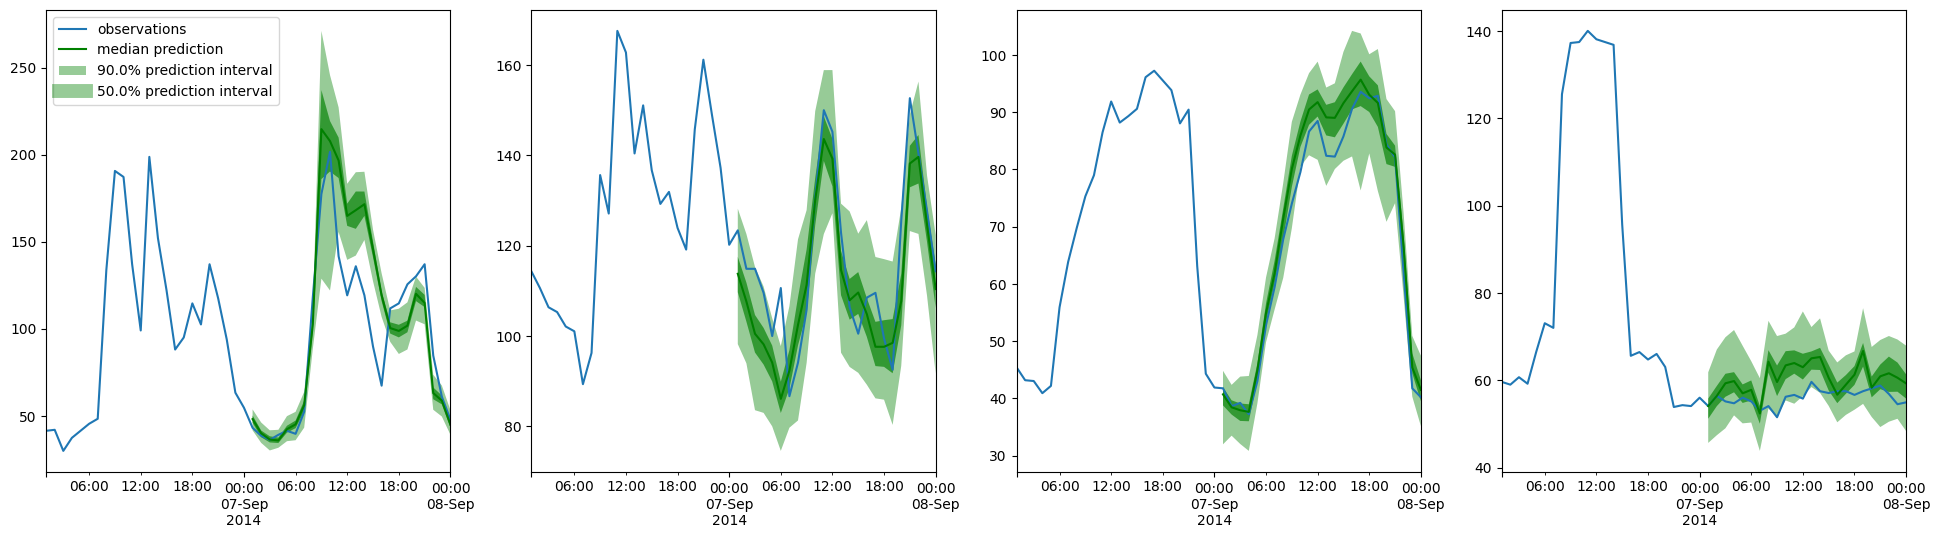

In [4]:
plot(targets_list[0][0], forecasts_list[0][0], prediction_length=dataset.metadata.prediction_length)

In [5]:
print("===============================================")
print("evaluation metrics")

agg_metric_list = []
for cur_gran_index, cur_gran in enumerate(mg_dict):
    evaluator = MultivariateEvaluator(quantiles=(np.arange(20) / 20.0)[1:],
                                      target_agg_funcs={'sum': np.sum})
    agg_metric, item_metrics = evaluator(targets_list[cur_gran_index], forecasts_list[cur_gran_index],
                                         num_series=len(data_test)/2)
    agg_metric_list.append(agg_metric)
    break # only evaluate the first gran

for cur_gran_index, cur_gran in enumerate(mg_dict):
    agg_metric = agg_metric_list[cur_gran_index]
    print(f"=======evaluation metrics for {cur_gran} h samples")
    print("CRPS:", agg_metric["mean_wQuantileLoss"])
    print("ND:", agg_metric["ND"])
    print("NRMSE:", agg_metric["NRMSE"])
    print("")
    print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
    print("ND-Sum:", agg_metric["m_sum_ND"])
    print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])
    break # only evaluate the first gran



evaluation metrics


Running evaluation: 7it [00:00, 116.53it/s]
Running evaluation: 7it [00:00, 132.66it/s]
Running evaluation: 7it [00:00, 136.58it/s]
Running evaluation: 7it [00:00, 137.14it/s]
Running evaluation: 7it [00:00, 128.57it/s]
Running evaluation: 7it [00:00, 132.03it/s]
Running evaluation: 7it [00:00, 128.11it/s]
Running evaluation: 7it [00:00, 125.91it/s]
Running evaluation: 7it [00:00, 123.63it/s]
Running evaluation: 7it [00:00, 124.37it/s]
Running evaluation: 7it [00:00, 124.14it/s]
Running evaluation: 7it [00:00, 130.06it/s]
Running evaluation: 7it [00:00, 132.07it/s]
Running evaluation: 7it [00:00, 132.08it/s]
Running evaluation: 7it [00:00, 132.39it/s]
Running evaluation: 7it [00:00, 129.92it/s]
Running evaluation: 7it [00:00, 131.66it/s]
Running evaluation: 7it [00:00, 133.46it/s]
Running evaluation: 7it [00:00, 131.18it/s]
Running evaluation: 7it [00:00, 133.37it/s]
Running evaluation: 7it [00:00, 126.31it/s]
Running evaluation: 7it [00:00, 119.98it/s]
Running evaluation: 7it [00:00, 

=======evaluation metrics for 1.0 h samples
CRPS: 0.051012248634461944
ND: 0.06619535858827373
NRMSE: 0.5372861410443673

CRPS-Sum: 0.015206596042023056
ND-Sum: 0.019457483398679247
NRMSE-Sum: 0.02561256802551425
